# Rust prototype 

This notebook is used for analyzing the latency properties of the Rust prototype, whose code is stored in `<project root>/rust/realtime`.

## Running the experiment

For a more detailed explanation of how the latency experiment run on the different prototypes works, see the "Running the experiment" section in [05_results_python.ipynb](./05_results_python.ipynb). This notebook will just explain the commands necessary to build the Rust prototype and run the latency procedure on it for the echo and LMS filters.

### Dependencies

In order to build and run the Rust prototype, you will need a local installation of both Rust and its build tool Cargo. Instructions for installing and setting up Rust and Cargo can be found [here](https://www.rust-lang.org/tools/install).

### Building the binary

Unlike Python and Julia, Rust is not an interpreted language, and requires that a program be compiled into a binary before being run. To build the binary for the Rust prototype, first navigate to `<project root>/rust/realtime`, and then run the command:
```console
> cargo build --release
```
Make sure to use the `--release` option when building the binary -- this instructs the Rust compiler to use all available optimizations to speed up the code. If the build process runs successfully, the resulting binary will be located at `<project root>/rust/realtime/target/release/realtime`.

### Echo filter

To run the latency procedure for the echo filter, you will need two separate terminal windows (make sure the project root is the working directory in both terminals). First, use the following command to launch the processor in the first terminal:
```console
>  rust/realtime/target/release/realtime processor --host 127.0.0.1 --port 8889 --filter echo
```
Once the processor instance is running, use this command to start the probe in the second terminal (this will start the experiment):
```console
> rust/realtime/target/release/realtime probe --host 127.0.0.1 --port 8889 --input data/processed/test_spks.h5 --output data/results/rust_echo.h5
```
This setup runs both the processor and probe instances on `localhost`, communicating through port 8889. To run them on different machines or a different port, just change these values.

### LMS filter

To run the experiment for the LMS filter, use the same commands with the `--filter` option for the processor instance changed from `echo` to `lms`, and the output filename changed:

Terminal 1:
```console
>  rust/realtime/target/release/realtime processor --host 127.0.0.1 --port 8889 --filter lms
```
Terminal 2:
```console
> rust/realtime/target/release/realtime probe --host 127.0.0.1 --port 8889 --input data/processed/test_spks.h5 --output data/results/rust_lms.h5
```

## Imports

In [1]:
import numpy as np
import h5py
from matplotlib import pyplot as plt

## Load filter outputs from file

In [2]:
ECHO_FPATH = '../data/results/rust_echo.h5'
LMS_FPATH = '../data/results/rust_lms.h5'

with h5py.File(ECHO_FPATH, 'r') as f:
    fp_echo = f['filter_preds'][:]
    rt_echo = f['rt_times_us'][:]
    
with h5py.File(LMS_FPATH, 'r') as f:
    fp_lms = f['filter_preds'][:]
    rt_lms = f['rt_times_us'][:]

## Latency distribution

### Summary statistics

In [3]:
print('Echo filter')
print(f'    min: {np.min(rt_echo):.2f} us')
print(f'    max: {np.max(rt_echo):.2f} us')
print(f'    mean: {np.mean(rt_echo):.2f} us')
print(f'    median: {np.median(rt_echo):.2f} us')

print('')
print('LMS filter')
print(f'    min: {np.min(rt_lms):.2f} us')
print(f'    max: {np.max(rt_lms):.2f} us')
print(f'    mean: {np.mean(rt_lms):.2f} us')
print(f'    median: {np.median(rt_lms):.2f} us')

Echo filter
    min: 34.31 us
    max: 349.59 us
    mean: 42.24 us
    median: 37.01 us

LMS filter
    min: 10482.60 us
    max: 47593.51 us
    mean: 11422.58 us
    median: 11173.65 us


### Full distribution

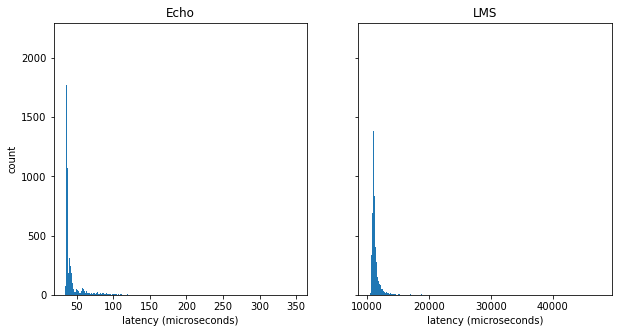

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

ax[0].set_title('Echo');
ax[0].hist(rt_echo, bins=500)
ax[0].set(ylabel='count')
ax[0].set(xlabel='latency (microseconds)')

ax[1].set_title('LMS');
ax[1].hist(rt_lms, bins=500);
ax[1].set(xlabel='latency (microseconds)');

### Distribution with outliers removed

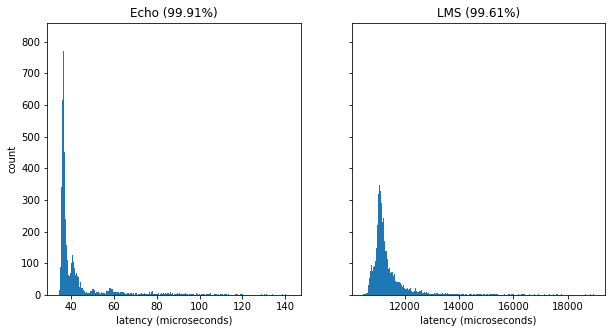

In [5]:
# Max values for histogram (all larger values will be excluded)
ECHO_MAX = 150
LMS_MAX = 19000

# Latency values to plot
rt_echo_plt = rt_echo[rt_echo < ECHO_MAX]
rt_lms_plt = rt_lms[rt_lms < LMS_MAX]

# Percentages of values included
pct_echo = rt_echo_plt.shape[0] / rt_echo.shape[0] * 100
pct_lms = rt_lms_plt.shape[0] / rt_lms.shape[0] * 100

fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

ax[0].set_title(f'Echo ({pct_echo:.2f}%)');
ax[0].hist(rt_echo[rt_echo < ECHO_MAX], bins=500)
ax[0].set(ylabel='count')
ax[0].set(xlabel='latency (microseconds)')

ax[1].set_title(f'LMS ({pct_lms:.2f}%)');
ax[1].hist(rt_lms[rt_lms < LMS_MAX], bins=500);
ax[1].set(xlabel='latency (microseconds)');